In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv


In [2]:
df=pd.read_csv("/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Flatten,Dropout,Embedding
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re

In [4]:
def unique_words(word,rating=None):
    words=[]
    stopwords=set(STOPWORDS)
    some_more_common_words=set(['hotel','room','service','rooms','stayed','just','no','not','staff'])
    stopwords.update(some_more_common_words)
    copy=df['Review']
    if rating!=None:
        copy=df[df['Rating']==rating]['Review']
    for y in copy:
        s=y.split(" ")
        for x in s:
            if x.isalpha() and x not in stopwords:
                words.append(x)
    return np.array(Counter(words).most_common(word))

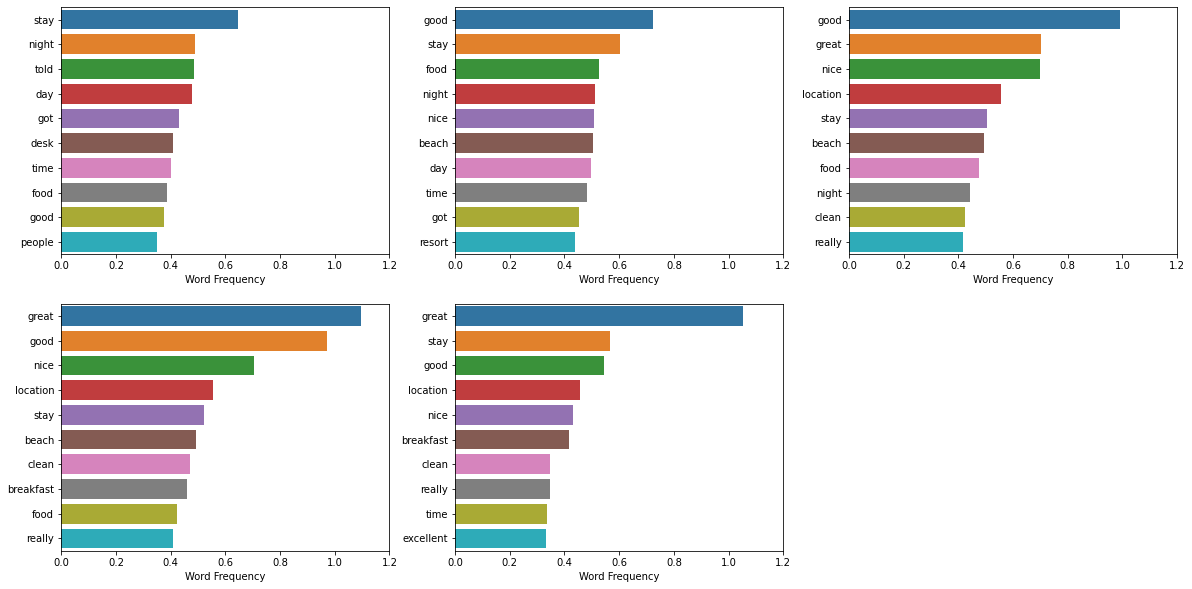

In [5]:
fig=plt.figure(figsize=(20,10))
counts=Counter(df['Rating'])
for rating in range(1,6):
    rated=unique_words(word=10,rating=rating)
    plt.subplot(2,3,rating)
    plt.xlabel('Word Frequency')
    plt.xlim([0,1.2])
    sns.barplot(y=rated[:,0],x=rated[:,1].astype(int)/counts[rating])
plt.show()

In [6]:
s=set()
stop=set(STOPWORDS)
lemma=WordNetLemmatizer()
for x in df['Review']:
    x=re.sub('[^A-Za-z]'," ",x)
    x=x.split(" ")
    for w in x:
        w=lemma.lemmatize(w)
        if w not in stop:
            s.add(w)
len(s)#number of distinct words

44760

In [7]:
def lemmatizer(x):
    x=re.sub('[^A-Za-z]',' ',x)
    s=x.split(" ")
    h=[]
    for y in s:
        y=lemma.lemmatize(y)
        if y not in stop:
            h.append(y)
    return " ".join(h)      

In [8]:
df['nlp_text']=df['Review'].apply(lambda x: lemmatizer(x))

In [9]:
df.head()

,Review,Rating,nlp_text
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experience hotel monaco seattle g...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monac...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game aweso...


In [10]:
num_words=20000
tokenizer=Tokenizer(num_words=num_words,oov_token='OOV')
tokenizer.fit_on_texts(df['nlp_text'])
tokenized_text=tokenizer.texts_to_sequences(df['nlp_text'])
np.mean([len(x) for x in tokenized_text])

99.82797325655166

In [11]:
length=100
tokenized_text=pad_sequences(tokenized_text,length,padding='post',truncating='post')
output=to_categorical(df['Rating'])
output=output[:,1:]

In [12]:
train,test,y_train,y_test=train_test_split(tokenized_text,output,test_size=0.2,random_state=21)

In [13]:
vector_space=32
model=Sequential()
model.add(Embedding(num_words,vector_space,input_length=length))
model.add(LSTM(16,return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(16,return_sequences=True,recurrent_dropout=0.2))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           640000    
_________________________________________________________________
lstm (LSTM)                  (None, 100, 16)           3136      
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 16)           2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6272      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [15]:
epoch=20
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
history=model.fit(train,y_train,validation_split=0.2,epochs=epoch,batch_size=1000)

Epoch 1/20
14/14 [==============================] - 8s 603ms/step - loss: 1.5789 - accuracy: 0.4088 - val_loss: 1.4952 - val_accuracy: 0.4440
Epoch 2/20
14/14 [==============================] - 8s 576ms/step - loss: 1.4225 - accuracy: 0.4367 - val_loss: 1.3658 - val_accuracy: 0.4440
Epoch 3/20
14/14 [==============================] - 7s 530ms/step - loss: 1.3711 - accuracy: 0.4240 - val_loss: 1.3451 - val_accuracy: 0.4440
Epoch 4/20
14/14 [==============================] - 8s 544ms/step - loss: 1.3570 - accuracy: 0.4390 - val_loss: 1.3317 - val_accuracy: 0.4440
Epoch 5/20
14/14 [==============================] - 7s 533ms/step - loss: 1.3123 - accuracy: 0.4386 - val_loss: 1.2261 - val_accuracy: 0.4440
Epoch 6/20
14/14 [==============================] - 8s 537ms/step - loss: 1.1614 - accuracy: 0.4317 - val_loss: 1.1026 - val_accuracy: 0.4831
Epoch 7/20
14/14 [==============================] - 7s 523ms/step - loss: 1.0816 - accuracy: 0.4860 - val_loss: 1.0721 - val_accuracy: 0.4983
Epoch 

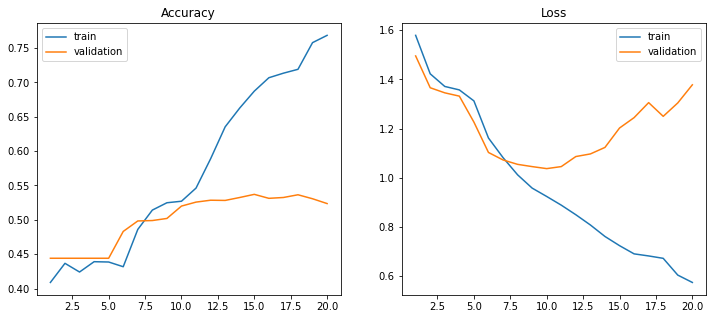

In [16]:
h=history.history
fig=plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(range(1,epoch+1),h['accuracy'],label='train')
plt.plot(range(1,epoch+1),h['val_accuracy'],label='validation')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(range(1,epoch+1),h['loss'],label='train')
plt.plot(range(1,epoch+1),h['val_loss'],label='validation')
plt.legend()
plt.show()

In [17]:
train,test,y_train,y_test=train_test_split(tokenized_text,df['Rating'],test_size=0.2,random_state=21)

In [18]:
model=Sequential()
model.add(Embedding(num_words,vector_space,input_length=length))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='relu'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           640000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 657,025
Trainable params: 657,025
Non-trainable params: 0
_________________________________________________________________


In [20]:
epoch=20
model.compile(optimizer='Adam',loss='mse',metrics='mae')
history=model.fit(train,y_train,epochs=epoch,batch_size=250,validation_split=0.2)

Epoch 1/20
53/53 [==============================] - 5s 89ms/step - loss: 5.9855 - mae: 1.9224 - val_loss: 1.4907 - val_mae: 0.9350
Epoch 2/20
53/53 [==============================] - 4s 81ms/step - loss: 1.4904 - mae: 0.9583 - val_loss: 1.4454 - val_mae: 0.9458
Epoch 3/20
53/53 [==============================] - 4s 85ms/step - loss: 1.4565 - mae: 0.9510 - val_loss: 1.4264 - val_mae: 0.9471
Epoch 4/20
53/53 [==============================] - 4s 82ms/step - loss: 1.4001 - mae: 0.9302 - val_loss: 1.3860 - val_mae: 0.9412
Epoch 5/20
53/53 [==============================] - 4s 81ms/step - loss: 1.2483 - mae: 0.8677 - val_loss: 1.2679 - val_mae: 0.8779
Epoch 6/20
53/53 [==============================] - 4s 85ms/step - loss: 1.0257 - mae: 0.7708 - val_loss: 0.9687 - val_mae: 0.7729
Epoch 7/20
53/53 [==============================] - 5s 87ms/step - loss: 0.5837 - mae: 0.6059 - val_loss: 0.6701 - val_mae: 0.6408
Epoch 8/20
53/53 [==============================] - 4s 82ms/step - loss: 0.3794 - m

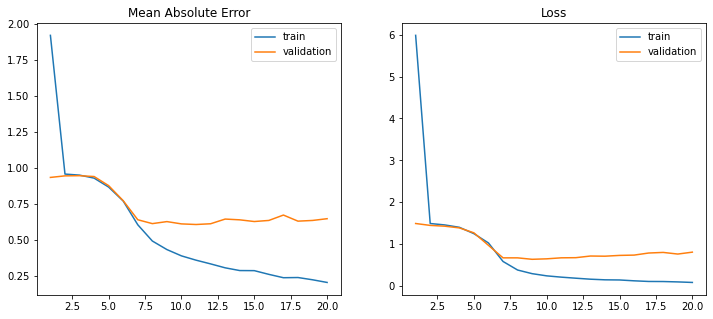

In [21]:
h=history.history
fig=plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Mean Absolute Error')
plt.plot(range(1,epoch+1),h['mae'],label='train')
plt.plot(range(1,epoch+1),h['val_mae'],label='validation')
plt.legend()
plt.subplot(1,2,2)
plt.title('Loss')
plt.plot(range(1,epoch+1),h['loss'],label='train')
plt.plot(range(1,epoch+1),h['val_loss'],label='validation')
plt.legend()
plt.show()

In [22]:
def get_preds(data,true_labels):
    pred=model.predict(data)
    h=[]
    for x in pred:
        if x-int(x)>=0.5:
            h.append(np.ceil(x))
        else :
            h.append(np.floor(x))
    print(pred[0:5])
    print(true_labels[:5])
    return accuracy_score(h,true_labels)

In [23]:
get_preds(train,y_train)

[[3.9303894]
 [4.7599854]
 [1.7428509]
 [3.8599377]
 [4.040611 ]]
10294    4
11753    5
16362    2
7074     4
14058    4
Name: Rating, dtype: int64


0.8448633479746218

In [24]:
get_preds(test,y_test)

[[3.7541776]
 [3.9464543]
 [4.977345 ]
 [4.78295  ]
 [4.086298 ]]
955      3
19500    5
19157    5
17671    5
17723    5
Name: Rating, dtype: int64


0.5125640400097585